In [434]:
import pandas as pd
import numpy as np

raw_users = pd.read_json('data/users.jsonl', lines=True)
raw_products = pd.read_json('data/products.jsonl', lines=True)
raw_sessions = pd.read_json('data/sessions.jsonl', lines=True)
raw_deliveries = pd.read_json('data/deliveries.jsonl', lines=True)

In [435]:
raw_users.dtypes

user_id     int64
name       object
city       object
street     object
dtype: object

In [436]:
raw_products.dtypes

product_id         int64
product_name      object
category_path     object
price            float64
dtype: object

In [437]:
raw_deliveries.dtypes

purchase_id             int64
purchase_timestamp     object
delivery_timestamp     object
delivery_company      float64
dtype: object

In [438]:
raw_sessions.dtypes

session_id                   int64
timestamp           datetime64[ns]
user_id                    float64
product_id                 float64
event_type                  object
offered_discount             int64
purchase_id                float64
dtype: object

### Clean user data

In [439]:
users = raw_users.astype({
    'user_id': 'float64'
})
users.set_index('user_id')
identities = users.name.apply(lambda n: n.strip().split(' ')).apply(pd.Series)
columns = ['name_1', 'name_2', 'surname']
two_named = identities[identities[2].isnull()][[0,2,1]]
two_named.columns = columns
identities.columns = columns
identities = pd.concat([identities[~identities.surname.isnull()], two_named]).sort_index()
users = pd.concat([users, identities], axis=1).drop('name', axis=1)
users['female'] = users.name_1.apply(lambda n: n.endswith('a'))
users.head()

,user_id,city,street,name_1,name_2,surname,female
0,102.0,Warszawa,plac Krakowska 69,Juliusz,NaN,Męcik,False
1,103.0,Radom,ul. Bursztynowa 56/10,Eliza,NaN,Miętka,True
2,104.0,Warszawa,plac Wiślana 99,Kacper,NaN,Kolarz,False
3,105.0,Gdynia,ulica Zwycięstwa 76/98,Tobiasz,NaN,Radko,False
4,106.0,Kutno,plac Głogowa 53/95,Roksana,NaN,Merchel,True


### Clean product data

In [440]:
products = raw_products.astype({
    'product_id': 'float64', 
    'category_path': 'unicode',
})
products.set_index('product_id')
categories = products.category_path.apply(lambda s: s.split(';')).apply(pd.Series)
categories = categories.rename(columns = lambda x : 'cat_' + str(x))
products = pd.concat([products, categories], axis=1)
products['main_category'] = products.cat_0
products.head()

,product_id,product_name,category_path,price,cat_0,cat_1,cat_2,cat_3,main_category
0,1001.0,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,Telefony i akcesoria,Telefony stacjonarne,NaN,NaN,Telefony i akcesoria
1,1002.0,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50,Komputery,Drukarki i skanery,Biurowe urządzenia wielofunkcyjne,NaN,Komputery
2,1003.0,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00,Komputery,Drukarki i skanery,Biurowe urządzenia wielofunkcyjne,NaN,Komputery
3,1004.0,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,Gry i konsole,Gry na konsole,Gry Xbox 360,NaN,Gry i konsole
4,1005.0,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,Gry i konsole,Gry na konsole,Gry Xbox 360,NaN,Gry i konsole


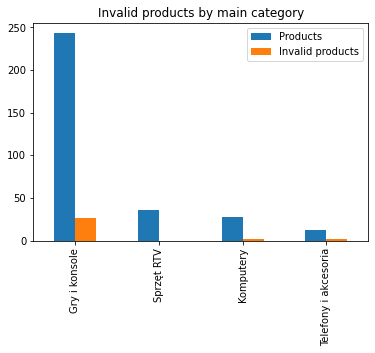

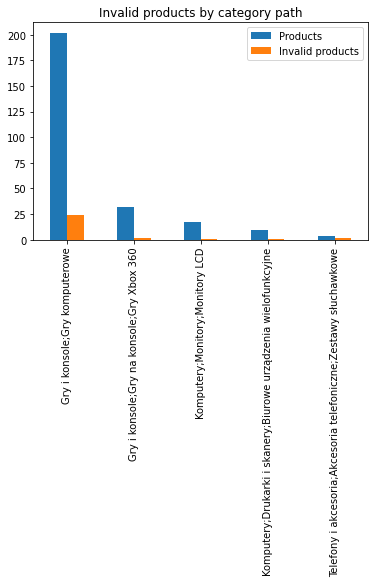

In [441]:
# analyse invalid products
invalid_prices_filter = (products['price']>0) & (products['price']<100000)

pd.concat([
    products['main_category'].value_counts().rename('Products'), 
    products[~invalid_prices_filter]['main_category'].value_counts().rename('Invalid products')
          ], axis=1).fillna(value=0).sort_values(by='Products', ascending=False).plot(kind='bar', 
        title='Invalid products by main category')

cp_df = pd.concat([
    products['category_path'].value_counts().rename('Products'), 
    products[~invalid_prices_filter]['category_path'].value_counts().rename('Invalid products')
          ], axis=1).fillna(value=0).sort_values(by='Products', ascending=False)
cp_df[cp_df['Invalid products']>0].plot(kind='bar', title='Invalid products by category path')

In [442]:
cat_df = pd.concat([
    products['category_path'].value_counts().rename('Products'), 
    products[~invalid_prices_filter]['category_path'].value_counts().rename('Invalid products')
          ], axis=1).fillna(value=0)
cat_df['invalid_percent'] = cat_df.apply(lambda r: round(100*r['Invalid products']/r['Products'],1), axis=1)
cat_df[cat_df['invalid_percent'] > 0].sort_values(by='Invalid products', ascending=False)


,Products,Invalid products,invalid_percent
Gry i konsole;Gry komputerowe,202,24.0,11.9
Gry i konsole;Gry na konsole;Gry Xbox 360,32,2.0,6.2
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,4,2.0,50.0
Komputery;Monitory;Monitory LCD,17,1.0,5.9
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,9,1.0,11.1


In [443]:
# Filter invalid prices: out of range (0.01, 100 000)
products['is_price_invalid'] = ~invalid_prices_filter

print('Detected {:.1f}% invalid rows (before {}, after {}).'.format(
    100-100*len(products[invalid_prices_filter])/len(raw_products), 
    len(products[invalid_prices_filter]), len(raw_products)))

Detected 9.4% invalid rows (before 289, after 319).


In [444]:
products.head()

,product_id,product_name,category_path,price,cat_0,cat_1,cat_2,cat_3,main_category,is_price_invalid
0,1001.0,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,Telefony i akcesoria,Telefony stacjonarne,NaN,NaN,Telefony i akcesoria,False
1,1002.0,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50,Komputery,Drukarki i skanery,Biurowe urządzenia wielofunkcyjne,NaN,Komputery,False
2,1003.0,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00,Komputery,Drukarki i skanery,Biurowe urządzenia wielofunkcyjne,NaN,Komputery,False
3,1004.0,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,Gry i konsole,Gry na konsole,Gry Xbox 360,NaN,Gry i konsole,False
4,1005.0,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,Gry i konsole,Gry na konsole,Gry Xbox 360,NaN,Gry i konsole,False


### Clean session data

In [445]:
sessions = raw_sessions.astype({
    'session_id': 'float64'
})
sessions['made_purchase'] = sessions.purchase_id.map(lambda x: False if pd.isnull(x) else True)

sessions.dtypes

session_id                 float64
timestamp           datetime64[ns]
user_id                    float64
product_id                 float64
event_type                  object
offered_discount             int64
purchase_id                float64
made_purchase                 bool
dtype: object

In [446]:
valid_session_cond = sessions['product_id'].isin(products['product_id'].unique()) & sessions['user_id'].isin(users['user_id'].unique())

#### Invalid sessions OVER CONVERSIONS

In [447]:
sessions['known_product'] = sessions['product_id'].isin(products['product_id'].unique())

sessions.groupby(['known_product', 'made_purchase']).session_id.count()

known_product  made_purchase
False          False             1570
               True               191
True           False            29670
               True              3342
Name: session_id, dtype: int64

#### Invalid sessions NO USER ID

In [448]:
sessions['is_user_invalid'] = ~sessions.apply(lambda row: row['user_id'] in users['user_id'].unique(), axis=1)
sessions.groupby(['is_user_invalid', 'made_purchase']).session_id.count()


is_user_invalid  made_purchase
False            False            29711
                 True              3366
True             False             1529
                 True               167
Name: session_id, dtype: int64

#### Invalid sessions OVER USERS

count    201.000000
mean       5.642680
std        7.441606
min        0.000000
25%        3.846154
50%        4.907975
75%        6.140351
max      100.000000
Name: invalid_percent_per_user, dtype: float64

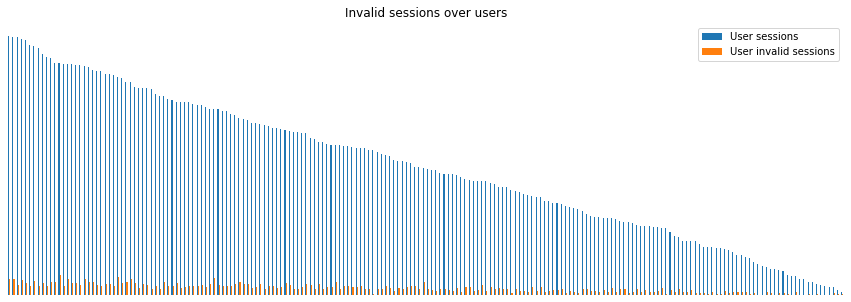

In [449]:
plt = pd.concat([
    sessions['user_id'].value_counts().rename('User sessions'), 
    sessions[~valid_session_cond]['user_id'].value_counts().rename('User invalid sessions')
          ], axis=1).fillna(value=0).sort_values(by='User sessions', ascending=False)\
    .plot(kind='bar', title='Invalid sessions over users', figsize=(15,5), xticks=None).axis('off')


df = pd.concat([
    sessions['user_id'].value_counts(dropna=False).rename('User sessions'), 
    sessions[~valid_session_cond]['user_id'].value_counts(dropna=False).rename('User invalid sessions')
          ], axis=1).fillna(value=0).sort_values(by='User sessions', ascending=False)
df['invalid_percent_per_user'] = df.apply(lambda r: 100*r['User invalid sessions']/r['User sessions'], axis=1)
df['invalid_percent_per_user'].describe()

#### Invalid sessions OVER TIME

(-0.5, 88.5, 0.0, 574.35)

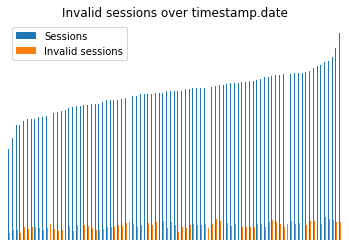

In [450]:
sessions['timestamp_date'] = sessions['timestamp'].dt.date

pd.concat([
    sessions['timestamp_date'].value_counts().rename('Sessions'), 
    sessions[~valid_session_cond]['timestamp_date'].value_counts().rename('Invalid sessions')
          ], axis=1).fillna(value=0).sort_values(by='Sessions', ascending=True)\
    .plot(kind='bar', title='Invalid sessions over timestamp.date').axis('off')


#### Filtering sessions

In [451]:
print('Detected {:.1f}% invalid rows (before {}, after {}).'.format(
    100-100*len(sessions[valid_session_cond])/len(raw_sessions), len(raw_sessions), len(sessions[valid_session_cond])))


sessions.head()

Detected 9.7% invalid rows (before 34773, after 31395).


,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,made_purchase,known_product,is_user_invalid,timestamp_date
0,100001.0,2020-01-17 16:08:57,102.0,1001.0,VIEW_PRODUCT,0,NaN,False,True,False,2020-01-17
1,100002.0,2020-01-07 05:10:41,102.0,1277.0,VIEW_PRODUCT,20,NaN,False,True,False,2020-01-07
2,100002.0,2020-01-07 05:14:26,102.0,1276.0,VIEW_PRODUCT,20,NaN,False,True,False,2020-01-07
3,100003.0,2020-01-16 09:37:42,102.0,1276.0,VIEW_PRODUCT,0,NaN,False,True,False,2020-01-16
4,100003.0,2020-01-16 09:38:22,102.0,1277.0,VIEW_PRODUCT,0,NaN,False,True,False,2020-01-16


### Clean delivery data

In [452]:
deliveries = raw_deliveries.astype({
    'purchase_id': 'float64', 
    'delivery_timestamp': 'datetime64',
    'purchase_timestamp': 'datetime64'
})
deliveries.set_index('purchase_id')

deliveries.dtypes

purchase_id                  float64
purchase_timestamp    datetime64[ns]
delivery_timestamp    datetime64[ns]
delivery_company             float64
dtype: object

In [453]:
invalid_delivery_cond = deliveries.purchase_id.isin(sessions[valid_session_cond]['purchase_id'])
deliveries['is_delivery_invalid'] = invalid_delivery_cond

deliveries['is_delivery_invalid'].value_counts()

True     3183
False     350
Name: is_delivery_invalid, dtype: int64

In [454]:
deliveries['delivery_time'] = deliveries.apply(lambda row: row['delivery_timestamp'] - row['purchase_timestamp'], axis=1)
deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,is_delivery_invalid,delivery_time
0,20001.0,2020-01-13 00:29:10,2020-01-17 00:31:53,516.0,True,4 days 00:02:43
1,20002.0,2020-02-04 19:09:12,2020-02-06 19:13:06,516.0,True,2 days 00:03:54
2,20003.0,2020-01-16 14:40:39,2020-01-18 14:41:27,620.0,True,2 days 00:00:48
3,20004.0,2020-02-05 08:08:59,NaT,360.0,True,NaT
4,20005.0,2020-02-18 09:27:06,2020-02-21 09:31:35,620.0,False,3 days 00:04:29


In [455]:

print('Detected {:.1f}% invalid rows (before {}, after {}).'.format(
    100-100*len(deliveries[invalid_delivery_cond])/len(raw_deliveries), len(raw_deliveries), len(deliveries[invalid_delivery_cond])))


Detected 9.9% invalid rows (before 3533, after 3183).


## Merge datasets

In [456]:
data = sessions.merge(products, how='left', on='product_id')
data = data.merge(users, how='left', on='user_id')
data = data.merge(deliveries, how='left', on='purchase_id')
data = data.drop(['category_path', 'main_category', 'timestamp_date'], axis=1)

data.columns = [
    'session_id', 'time', 'user_id', 'product_id', 'event',
    'discount', 'purchase_id', 'made_purchase', 'known_product',
    'is_user_invalid', 'product', 'price', 'cat_0', 'cat_1', 'cat_2',
    'cat_3', 'is_price_invalid', 'city', 'street', 'name_1', 'name_2',
    'surname', 'female', 'purchase_time', 'delivery_time',
    'delivery_company', 'is_delivery_invalid', 'delivery_duration'
]
data.head()

data.columns

Index(['session_id', 'time', 'user_id', 'product_id', 'event', 'discount',
       'purchase_id', 'made_purchase', 'known_product', 'is_user_invalid',
       'product', 'price', 'cat_0', 'cat_1', 'cat_2', 'cat_3',
       'is_price_invalid', 'city', 'street', 'name_1', 'name_2', 'surname',
       'female', 'purchase_time', 'delivery_time', 'delivery_company',
       'is_delivery_invalid', 'delivery_duration'],
      dtype='object')

## Add event duration

In [457]:
def event_dur(row, times):
    next_event = min([t for t in times[row.session_id] if t > row.time], default=None)
    return min([(next_event - row.time).round('5s'), pd.Timedelta('10m')]) if next_event is not None else None

times = data.groupby('session_id').time.apply(list)
data['duration'] = data.apply(lambda row: event_dur(row, times), axis=1)
data['syntetic_duration'] = data.duration.isna()
mean = data.duration.mean()
data['duration'] = data.duration.fillna(value=mean)

## Add aggregated time spent on product

In [458]:
def time_spent_on_product(row, times):
    all_events = times['duration'][row.product_id][row.user_id]
    return all_events[all_events.index < row.time].sum()

zero_time = pd.Timedelta('0s')
times = data.set_index(['product_id', 'user_id', 'time'])
data['agg_time_spent'] = data.apply(lambda row: time_spent_on_product(row, times), axis=1).fillna(value=zero_time)

## Add weekday

In [459]:
data['weekday'] = data.time.apply(lambda t: t.weekday())

## Add hour

In [460]:
data['hour'] = data.time.apply(lambda t: t.hour)

## Add weekday sin and cos features

In [461]:
data['weekday_sin'] = np.sin(2*np.pi*data.weekday/7)
data['weekday_cos'] = np.cos(2*np.pi*data.weekday/7)

## Add hour sin and cos features

In [462]:
data['hour_sin'] = np.sin(2*np.pi*data.hour/24)
data['hour_cos'] = np.cos(2*np.pi*data.hour/24)

## Add session outcome

In [463]:
grouped = data.groupby('session_id').made_purchase.any()
data['ends_with_purchase'] = data.session_id.apply(lambda id: grouped[id])

# Save merged

In [477]:
data = data.astype({'female': 'bool', 'ends_with_purchase': 'bool'})

string_cols = ['event', 'product', 'cat_0', 'cat_1', 'cat_2', \
               'cat_3', 'city', 'street', 'name_1', 'name_2', 'surname']

for col in string_cols:
    data[col] = data[col].astype(str).str.lower()
    
data['is_user_invalid'].fillna(False, inplace=True)
data['is_delivery_invalid'].fillna(False, inplace=True)
data['is_price_invalid'].fillna(False, inplace=True)

## Save with missing data

In [465]:
data.to_pickle('data/merged_with_missing.pickle')

## Save only valid

In [483]:
data[['is_user_invalid', 'is_delivery_invalid']]
data['is_price_invalid'].value_counts()

False    32784
True      1989
Name: is_price_invalid, dtype: int64

In [485]:
valid_data = data[~data['is_user_invalid'] & ~data['is_delivery_invalid'] & ~data['is_price_invalid'] & data['known_product']]


In [ ]:
valid_data = data.drop(['is_user_invalid', 'is_delivery_invalid','is_price_invalid',], axis=1)

In [ ]:
valid_data.to_json('data/merged.jsonl', orient='records', lines=True)
valid_data.to_pickle('data/merged.pickle')